# Movie remakes analysis

In [1]:
# import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pickle as pkl
import openai
from scipy.stats import ttest_ind
from scipy.stats import linregress

from scipy.stats import kstest
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import t


import json
from ada_config.config import CONFIG

## Loading data

In [2]:
# load movie metadata

# Load movie metadata
df_movies = pd.read_csv(CONFIG["data_path"] / "enrich_movie_data2.csv")

# Load charachter metadata
df_chars  = pd.read_csv(CONFIG["cmu_path"] / "character_metadata.csv")

# load movie remakes data
movie_remakes_df = pd.read_csv(CONFIG["data_path"] / 'remakes.csv')

C:\Users\Amirmahdi\AppData\Local\Temp\ipykernel_2592\2009979882.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv(CONFIG["data_path"] / "enrich_movie_data2.csv")


In this notebook we refer to original and remakes. By original we mean the movie which a remake has been made for. For remakes, we mean the movies which are remakes for the original movies.

In [4]:
# drop nan values from wikidata id
movie_remakes_df = movie_remakes_df.dropna(subset=["remake_wikidata_id", "original_wikidata_id"])

In [5]:
# make the dataframes for original and remake movies.

original_movies_wikidata = list(movie_remakes_df["original_wikidata_id"].unique())

remakes_movies_wikidata = list(movie_remakes_df["remake_wikidata_id"].unique())

original_df = df_movies[df_movies["wikidata_id"].isin(original_movies_wikidata)]

remakes_df = df_movies[df_movies["wikidata_id"].isin(remakes_movies_wikidata)]

We have two main ideas to investigate:
- What are the differences between the original movies and their remakes.
- What factors affect a movie being remade or equivalently what are the different patterns between the original movies and the non-remade movies.

We will investigate these ideas next.

## 1 - Differences between Original and Remake

There are many factors that we could investigate their difference between the original movies and their remakes like revenue, genres, sentiment, budget, etc. Here we have investigated for revenue and we will set the rest of the analysis for the next phase.

 We will compare the revenue of the original movies and the remakes. We will also investigate the distribution of the revenue of the original movies and the remakes. It seems that remake revenues has a similar distribution to the original movies in the log scale with a shifted mean.

In [6]:
original_revenue = original_df["adjusted_revenue"].dropna()
remakes_revenue = remakes_df["adjusted_budget"].dropna()

original_revenue_log = np.log(original_revenue)
remakes_revenue_log = np.log(remakes_revenue)

# filter outliers with 95% confidence interval
original_revenue_log_mean = original_revenue_log.mean()
original_revenue_log_std = original_revenue_log.std()

remakes_revenue_log_mean = remakes_revenue_log.mean()
remakes_revenue_log_std = remakes_revenue_log.std()

original_revenue_log_filtered = original_revenue_log[(original_revenue_log > original_revenue_log_mean - 2 * original_revenue_log_std) & (original_revenue_log < original_revenue_log_mean + 2 * original_revenue_log_std)]
remakes_revenue_log_filtered = remakes_revenue_log[(remakes_revenue_log > remakes_revenue_log_mean - 2 * remakes_revenue_log_std) & (remakes_revenue_log < remakes_revenue_log_mean + 2 * remakes_revenue_log_std)]

original_revenue_filtered = np.exp(original_revenue_log_filtered)
remakes_revenue_filtered = np.exp(remakes_revenue_log_filtered)

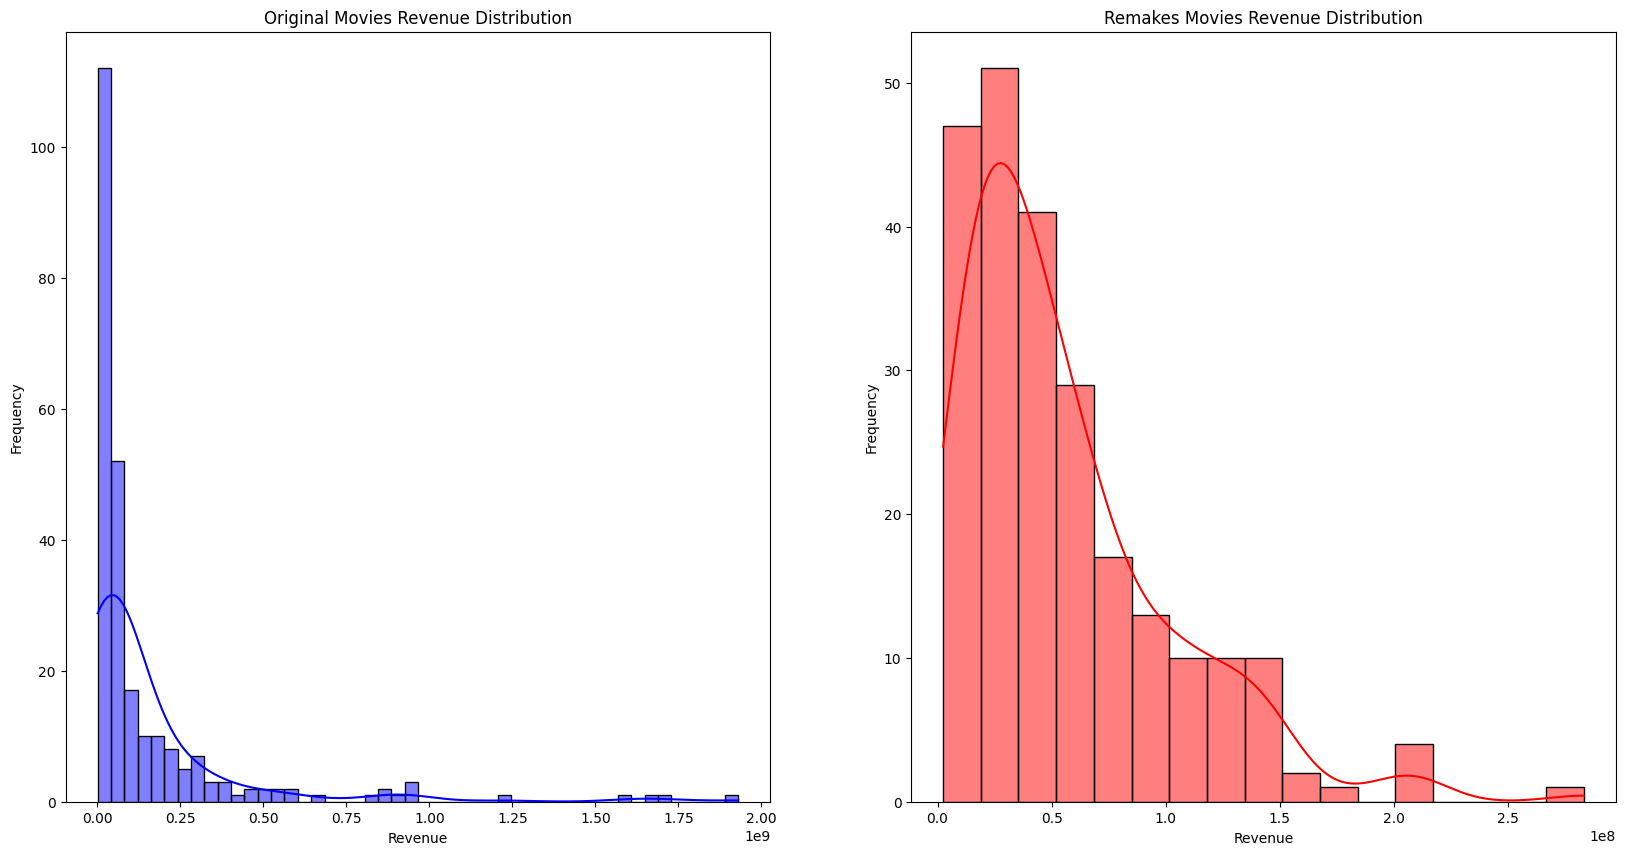

In [7]:
# plot distribition of remakes and original movies revenues

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.histplot(original_revenue_filtered, ax=ax[0], color="blue", kde=True)
ax[0].set_title("Original Movies Revenue Distribution")
ax[0].set_xlabel("Revenue")
ax[0].set_ylabel("Frequency")

sns.histplot(remakes_revenue_filtered, ax=ax[1], color="red", kde=True)
ax[1].set_title("Remakes Movies Revenue Distribution")
ax[1].set_xlabel("Revenue")
ax[1].set_ylabel("Frequency")

plt.show()

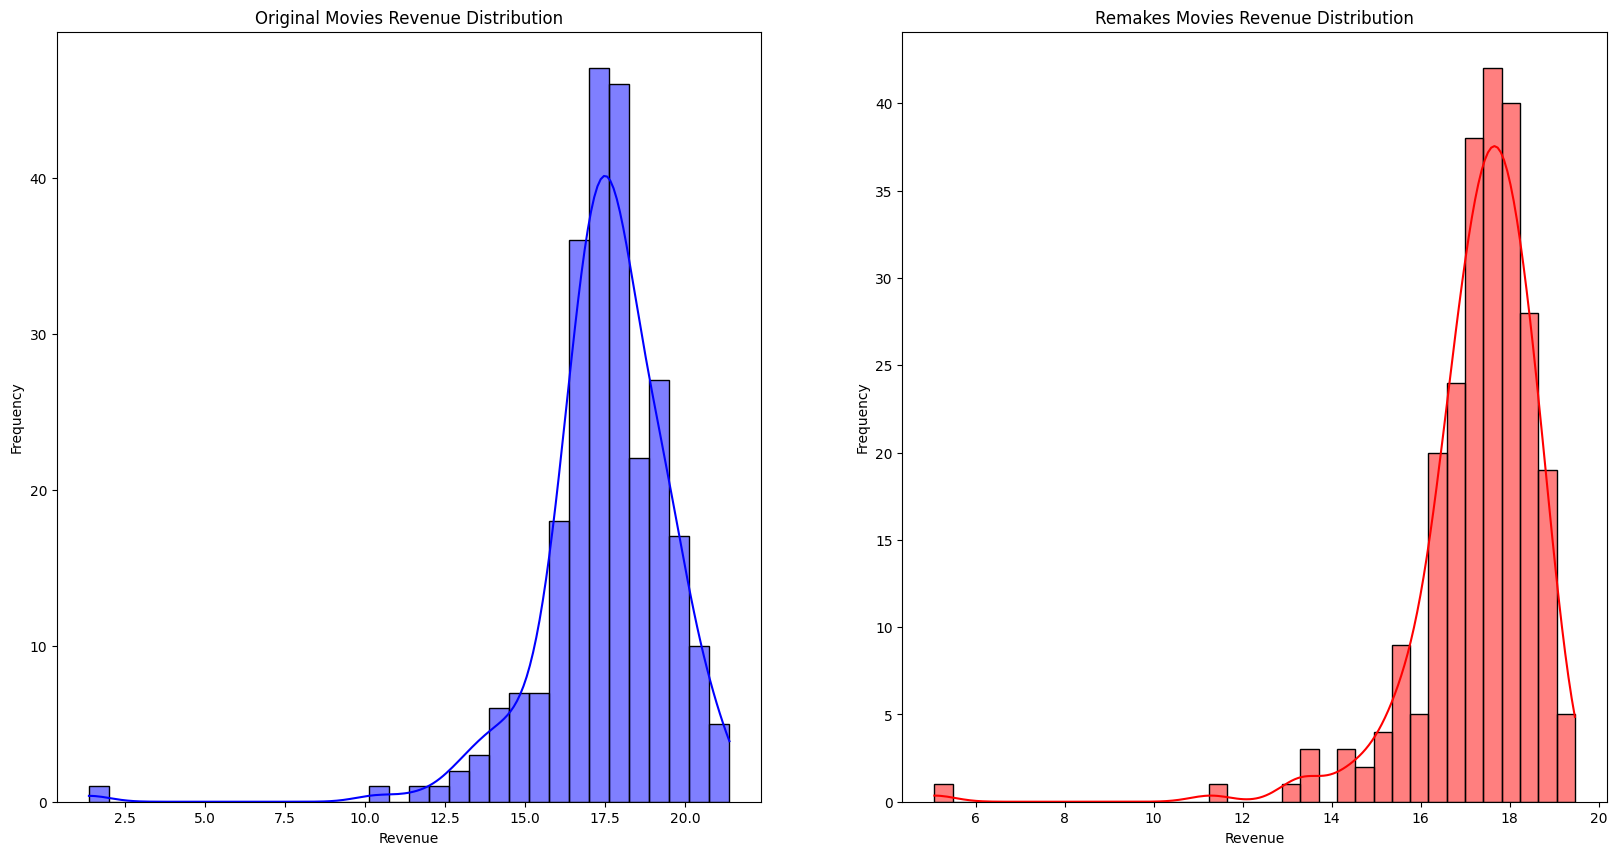

In [8]:
# plot the log distributions

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.histplot(original_revenue_log, ax=ax[0], color="blue", kde=True)
ax[0].set_title("Original Movies Revenue Distribution")
ax[0].set_xlabel("Revenue")
ax[0].set_ylabel("Frequency")

sns.histplot(remakes_revenue_log, ax=ax[1], color="red", kde=True)
ax[1].set_title("Remakes Movies Revenue Distribution")
ax[1].set_xlabel("Revenue")
ax[1].set_ylabel("Frequency")

plt.show()

## Distribution analysis

### 1 - Do the distributions follow a specific distribution?

#### **Kolmogorov-Smirnov Test (K-S Test)**

The Kolmogorov-Smirnov test is a non-parametric test used to determine whether a sample comes from a specific distribution. 

Test Description

The `kstest` function compares the empirical distribution function (EDF) of a sample with the cumulative distribution function (CDF) of a reference distribution.

Null Hypothesis ($H_0$):
The sample follows the specified reference distribution (in this case, the **exponential distribution**).

Alternative Hypothesis ($H_a$):
The sample does not follow the specified reference distribution.

Mathematical Formulation

1. **Kolmogorov-Smirnov Statistic**:
   $
   D = \sup_x \left| F_n(x) - F(x) \right|
   $
   where:
   - ($F_n(x)$): Empirical Distribution Function (EDF) of the sample.
   - ($F(x)$): Cumulative Distribution Function (CDF) of the specified reference distribution.

2. **Purpose of $D$**:
   - The test calculates the maximum absolute difference between the sample's empirical distribution $F_n(x)$ and the reference distribution's cumulative function $F(x)$ across all values of $x$.
   - This value $D$ represents the largest deviation between the observed data and the expected distribution under the null hypothesis.

3. **p-value Calculation**:
   - The p-value is calculated based on the value of $D$ to assess the probability of observing this or a more extreme deviation if the null hypothesis ($H_0$) were true. A lower p-value indicates a less likely match with the reference distribution.

Parameters in `kstest`:
- `original_revenue_filtered`: The sample data being tested.
- `"expon"`: Specifies the exponential distribution as the reference.

Interpretation of Results
- **If $p$-value < significance level $\alpha$:**
  Reject $H_0$. The sample does not follow an exponential distribution.
- **If $p$-value $\geq \alpha$:**
  Fail to reject $H_0$. The sample may follow an exponential distribution.

In [9]:
# test if the revenue of original movies and remakes are from the exponential distribution
# H0: the revenue of original movies and remakes are from the exponential distribution

print(kstest(original_revenue_filtered, "expon"))
print(kstest(remakes_revenue_filtered, "expon"))

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=865304.417837838, statistic_sign=-1)
KstestResult(statistic=1.0, pvalue=0.0, statistic_location=2450779.732682735, statistic_sign=-1)


In [10]:
# test if the revenue of original movies and remakes are from the poisson distribution
# H0: the revenue of original movies and remakes are from the poisson distribution

print(kstest(original_revenue_filtered, "poisson", args=(original_revenue_filtered.mean(),)))
print(kstest(remakes_revenue_filtered, "poisson", args=(remakes_revenue_filtered.mean(),)))


KstestResult(statistic=0.751004016064257, pvalue=7.010605513149926e-146, statistic_location=147612764.65672264, statistic_sign=1)
KstestResult(statistic=0.614406779661017, pvalue=3.249291136791497e-86, statistic_location=54729012.161297165, statistic_sign=1)


The revenues of the originals and the remakes are neither exponential nor poisson.

### 2 - Comparing the distributions of original and remakes revenues

We investigate the distributions of the original and the remakes in log scale. We consider the CCDF (from the slides) to reduce the noise. We observed they have close distribution with a shifted mean.

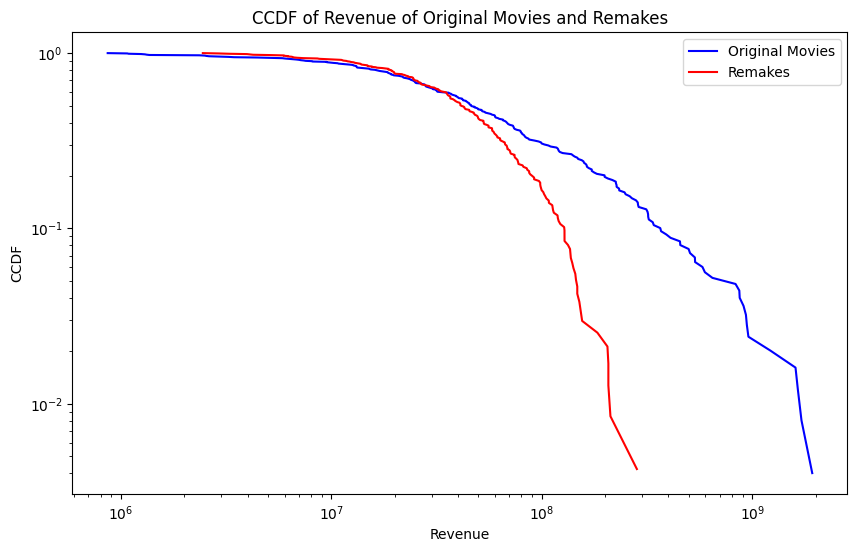

In [11]:
# sorting the data and calculating CCDF
# sorted_revenues = np.sort(original_revenue)
sorted_revenues = np.sort(original_revenue_filtered)
sorted_revenues = sorted_revenues[::-1]
ccdf = np.arange(1, len(sorted_revenues) + 1) / len(sorted_revenues)

# sorted_revenues_remakes = np.sort(remakes_revenue)
sorted_revenues_remakes = np.sort(remakes_revenue_filtered)
sorted_revenues_remakes = sorted_revenues_remakes[::-1]
ccdf_remakes = np.arange(1, len(sorted_revenues_remakes) + 1) / len(sorted_revenues_remakes)

# plotting the CCDF
plt.figure(figsize=(10, 6))

plt.plot(sorted_revenues, ccdf, color="blue", label="Original Movies")
plt.plot(sorted_revenues_remakes, ccdf_remakes, color="red", label="Remakes")

plt.title("CCDF of Revenue of Original Movies and Remakes")
plt.xlabel("Revenue")
plt.ylabel("CCDF")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
# test if the revenue of original movies and remakes have the same mean

origin_log = np.log(original_revenue_filtered)
remakes_log = np.log(remakes_revenue_filtered)

print(ttest_ind(origin_log, remakes_log))

# test whether the two distributions have the same shape/relative structure

origin_log -= origin_log.mean()
origin_log /= origin_log.std()

remakes_log -= remakes_log.mean()
remakes_log /= remakes_log.std()

print(ks_2samp(origin_log, remakes_log))

TtestResult(statistic=2.26549879500507, pvalue=0.02392406178927461, df=483.0)
KstestResult(statistic=0.08169968007623715, pvalue=0.3665073249994639, statistic_location=0.33012271418661204, statistic_sign=1)


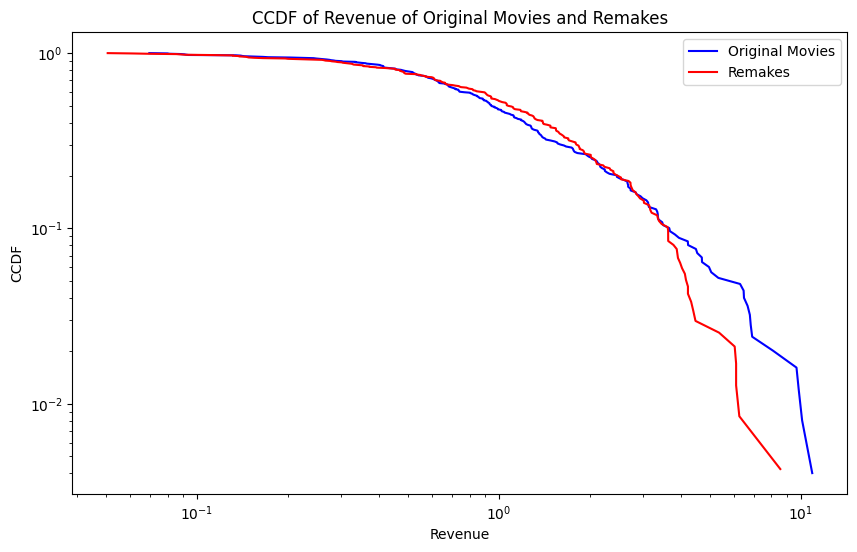

In [17]:
# sorting the data and calculating CCDF

origin_zmean = np.exp(origin_log)
remakes_zmean = np.exp(remakes_log)

sorted_revenues = np.sort(origin_zmean)
sorted_revenues = sorted_revenues[::-1]
ccdf = np.arange(1, len(sorted_revenues) + 1) / len(sorted_revenues)

sorted_revenues_remakes = np.sort(remakes_zmean)
sorted_revenues_remakes = sorted_revenues_remakes[::-1]
ccdf_remakes = np.arange(1, len(sorted_revenues_remakes) + 1) / len(sorted_revenues_remakes)

# plotting the CCDF
plt.figure(figsize=(10, 6))

plt.plot(sorted_revenues, ccdf, color="blue", label="Original Movies")
plt.plot(sorted_revenues_remakes, ccdf_remakes, color="red", label="Remakes")

plt.title("CCDF of Revenue of Original Movies and Remakes")
plt.xlabel("Revenue")
plt.ylabel("CCDF")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

## Variable Analysis 

In this part, we investigate whether there is a correlation between the original movies and their remakes.

In [38]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [21]:
movie_remakes_df_joined = pd.merge(movie_remakes_df, df_movies, left_on="remake_wikidata_id", right_on="wikidata_id", how="inner")

list_of_remakes_columns = movie_remakes_df_joined.columns[len(movie_remakes_df.columns):]
for column in list_of_remakes_columns:
    movie_remakes_df_joined.rename(columns={column: f'remake_{column}'}, inplace=True)


columns_number = len(movie_remakes_df_joined.columns)

movie_remakes_df_joined = pd.merge(movie_remakes_df_joined, df_movies, left_on="original_wikidata_id", right_on="wikidata_id", how="inner")
list_of_originals_columns = movie_remakes_df_joined.columns[columns_number:]
for column in list_of_originals_columns:
    movie_remakes_df_joined.rename(columns={column: f'original_{column}'}, inplace=True)


In [19]:
# TODO: mention that none of the original and remakes are adult and then drop them

In [ ]:
# TODO: add sentiment score and crew popularity score

# vote average, vote count, runtime, budget, revenue, popularity
list_of_numerical_columns = ["vote_average", "vote_count", "runtime", "adjusted_revenue", "adjusted_budget", "popularity"]

# for column in list_of_numerical_columns:
#     print(movie_remakes_df_joined["remake_" + column].isna().sum())
#     print(movie_remakes_df_joined["original_" + column].isna().sum())
    
original_num_columns = ["original_" + column for column in list_of_numerical_columns]
remake_num_columns = ["remake_" + column for column in list_of_numerical_columns]


def backward_elimination(X, y, significance_level=0.05):
    num_vars = X.shape[1]
    for _ in range(num_vars):
        model = sm.OLS(y, X).fit()
        non_constant_pvalues = model.pvalues.drop(labels=['const'], errors='ignore')
        max_p_value = non_constant_pvalues.max()
        if max_p_value > significance_level:
            excluded_feature = non_constant_pvalues.idxmax()
            # print(f'Dropping {excluded_feature} with p-value {max_p_value:.4f}')
            X = X.drop(columns=[excluded_feature])
        else:
            break
    return X, model


for remake_column in remake_num_columns:
    data = movie_remakes_df_joined.loc[:, original_num_columns + [remake_column]]
    data.dropna(inplace = True)
    print(f"number of remaining rows for {remake_column} = {len(data)}")
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    X, y = data_scaled[original_num_columns], data_scaled[[remake_column]]
    X = sm.add_constant(X)
    # model = sm.OLS(y, X).fit()
    X, model = backward_elimination(X, y)
    print(model.summary())
    print("###################################################################################")



number of remaining rows for remake_vote_average = 165
                             OLS Regression Results                            
Dep. Variable:     remake_vote_average   R-squared:                       0.098
Model:                             OLS   Adj. R-squared:                  0.092
Method:                  Least Squares   F-statistic:                     17.69
Date:                 Sun, 08 Dec 2024   Prob (F-statistic):           4.28e-05
Time:                         19:42:36   Log-Likelihood:                -225.62
No. Observations:                  165   AIC:                             455.2
Df Residuals:                      163   BIC:                             461.5
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

## 2 - Patterns of Movie to be Remade

In this part, we want to investigate which factors can impact a movie to be remade or not. In other words, we want to investigate what factors are different in original movies and the rest of the dataset.

We start by investigating the revenue factor to see whether revenue is an important factor.

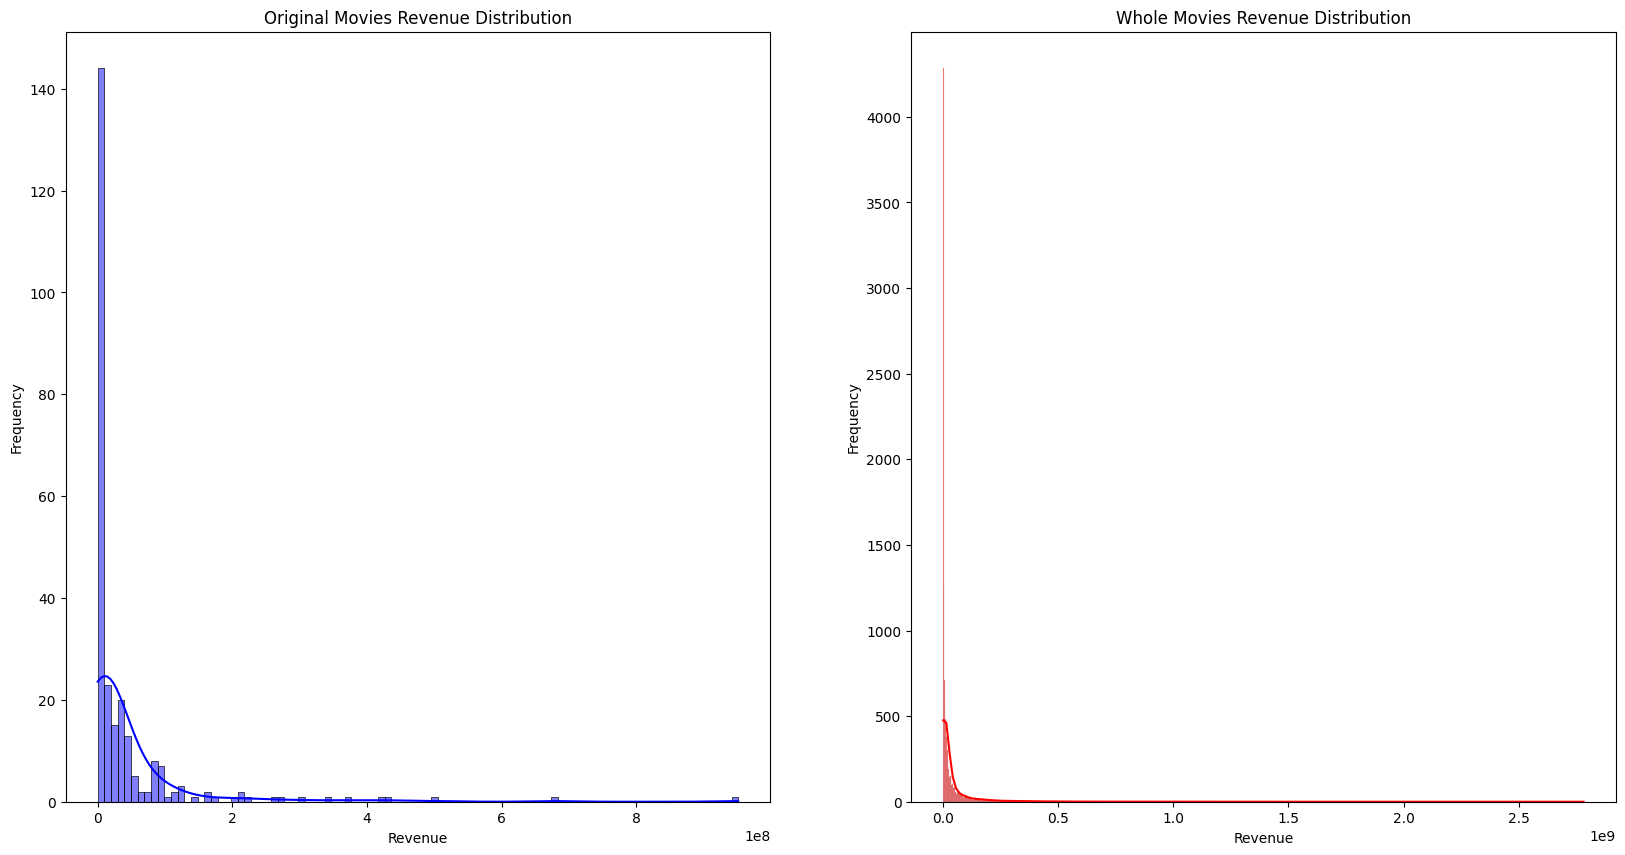

In [146]:
# plot distribition of remakes and original movies revenues

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.histplot(original_df["movie_revenue"], ax=ax[0], color="blue", kde=True)
ax[0].set_title("Original Movies Revenue Distribution")
ax[0].set_xlabel("Revenue")
ax[0].set_ylabel("Frequency")

sns.histplot(df_movies["movie_revenue"], ax=ax[1], color="red", kde=True)
ax[1].set_title("Whole Movies Revenue Distribution")
ax[1].set_xlabel("Revenue")
ax[1].set_ylabel("Frequency")

plt.show()

In [148]:
print("Mean revenue for original movies:", original_df["movie_revenue"].mean())

print("Mean revenue for whole dataset:", df_movies["movie_revenue"].mean())


Mean revenue for original movies: 41623667.003802285
Mean revenue for whole dataset: 41042168.831674956


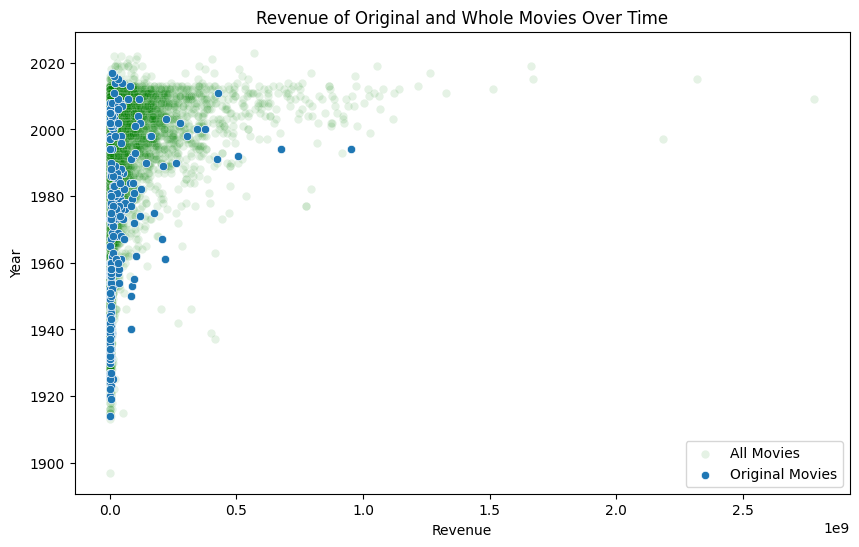

In [149]:
# scatter plot of revenues and runtimes of original movies
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_movies, x="movie_revenue", y="cmu_year", color="green", alpha=0.1, label="All Movies")

sns.scatterplot(data=original_df, x="movie_revenue", y="cmu_year", label="Original Movies")


plt.title("Revenue of Original and Whole Movies Over Time")
plt.xlabel("Revenue")
plt.ylabel("Year")
plt.show()

In order to investigate whether the revenue of the movies which have been remade (originals) and the whole set of movies are different we apply a **student's t** test.

In [168]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(original_df["movie_revenue"].dropna(), df_movies["movie_revenue"].dropna())
print(f"t-statistic: {t_stat}, p-value: {p_value}")


t-statistic: 0.08469796280101127, p-value: 0.9325028916963388


We observe that the p-value is very high meaning that we cannot reject the null hypothesis that the distributions are the same.

## Regression Analysis

We want to see whether a movie being remade or not affects its revenue or not. We apply regression and look at the significance of the coefficients.

To examine whether being a remake impacts a movie's revenue, we apply a linear regression model. In this analysis, the dependent variable $y$ represents the movie revenue, while the independent variables $X$ include features such as `remakes_bool` (indicating if a movie is a remake), `vote_average`, `vote_count`, `runtime`, `budget`, and `popularity`. We use a standardized version of $X$ for better interpretability of coefficients.

The regression model can be written as:
$$
y = \beta_0 + \beta_1 \cdot {remakes\_bool} + \beta_2 \cdot {vote\_average} + \dots + \beta_p \cdot \text{popularity} + \epsilon

$$

where $\beta_i$ represents the coefficients of each feature, and $\epsilon$ is the error term.

After fitting the model, we obtain the coefficients $\beta$, which indicate the effect of each feature on revenue. To test the statistical significance of each coefficient, we calculate the t-statistics:
$$
t_i = \frac{\beta_i}{\text{SE}(\beta_i)}
$$
where $\text{SE}(\beta_i)$ is the standard error of $\beta_i$, estimated by:
$$
\text{SE}(\beta_i) = \sqrt{\frac{\text{MSE}}{\sum (X_i - \bar{X}_i)^2}}
$$
with $\text{MSE}$ as the mean squared error.

Using the t-values, we compute the p-values to determine if each coefficient is significantly different from zero. A low p-value (typically $< 0.05$) indicates that the feature significantly affects movie revenue.

Finally, the model's $R^2$ value provides an overall measure of fit, showing the proportion of variance in revenue explained by the features in the model.


In [171]:
df_movies["remakes_bool"] = 0
df_movies["remakes_bool"] = df_movies["remakes_bool"].astype(float)
df_movies.loc[df_movies["wikidata_id"].isin(original_movies_wikidata), "remakes_bool"] = 1

df_movies_regression = df_movies[["movie_revenue", "remakes_bool", "vote_average", "vote_count", "runtime", "budget", "popularity"]].dropna()

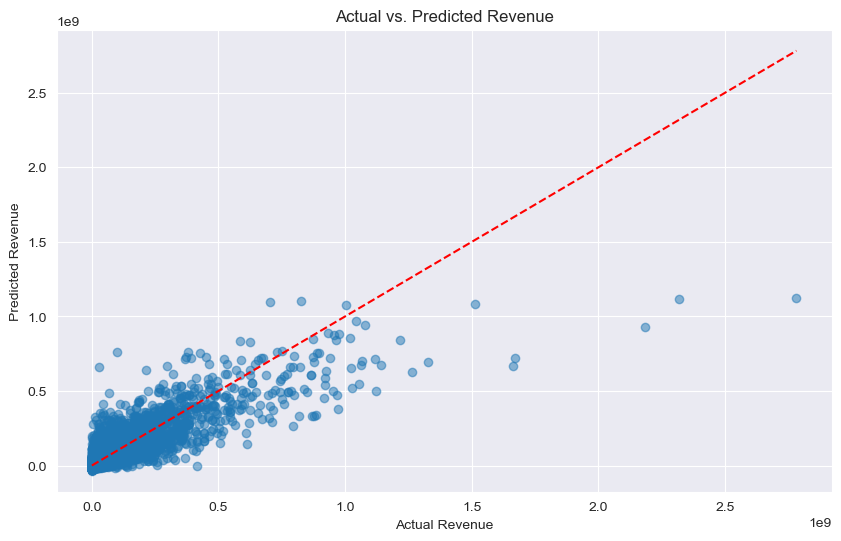

In [ ]:
scaler = StandardScaler()

X = df_movies_regression.drop(columns=["movie_revenue"])
y = df_movies_regression["movie_revenue"]

X_scaled = scaler.fit_transform(X)

regressor = LinearRegression()
regressor.fit(X_scaled, y)

y_pred = regressor.predict(X_scaled)

mse = mean_squared_error(y, y_pred)
r_squared = regressor.score(X_scaled, y)

# plot the predicted vs actual revenue

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs. Predicted Revenue")
plt.show()


In [ ]:
# check the statistical significance of the regression coefficients

n = len(y)
p = X_scaled.shape[1]

dof = n - p - 1

t_values = regressor.coef_ / np.sqrt(mse / np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2, axis=0))
p_values = 2 * (1 - t.cdf(np.abs(t_values), dof))

# Create a DataFrame to display the results
results = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": regressor.coef_,
    "t-value": t_values,
    "p-value": p_values
})

print(results)

        Feature   Coefficient    t-value   p-value
0  remakes_bool  7.938167e+05   0.897335  0.369571
1  vote_average -3.068303e+06  -3.468428  0.000527
2    vote_count  6.800233e+07  76.870258  0.000000
3       runtime  2.148477e+06   2.428652  0.015180
4        budget  5.800509e+07  65.569315  0.000000
5    popularity  8.030862e+06   9.078137  0.000000


## 3 - Sentiment analysis of the movie endings

We can also investigate the sentiment of the movie plots / summaries to see whether they are important factors in movie remakes.

In [174]:
OPENAI_API_KEY="YOUR_API_KEY"
gpt4_client = openai.OpenAI(api_key=OPENAI_API_KEY)


In [175]:
df_just_summaries = df_movies[['Wikipedia_movie_ID', 'movie_summary']]

In [176]:
# A positive, negative and neutral sentiment examples
# Negative sentiment means sad ending, positive sentiment means happy ending, neutral sentiment means the ending is neither happy nor sad
negative_sentiment_example = "Neil Perry , Todd Anderson , Knox Overstreet , Charlie Dalton , Richard Cameron , Steven Meeks , and Gerard Pitts  are senior students of the Welton Academy, an elite prep school, whose ethos is defined by the headmaster Gale Nolan  as ""tradition, honor, discipline and excellence"". Both Neil and Todd are under harsh parental pressure to become a doctor and a lawyer respectively, but Todd wants to be a writer, and Neil discovers a passion for acting. The teaching methods of their new English teacher, John Keating , are unorthodox by Welton standards, whistling the 1812 Overture and taking them out of the classroom to focus on the idea of carpe diem. He tells the students that they may call him ""O Captain! My Captain!,"" in reference to a Walt Whitman poem, if they feel daring. In another class, Keating has Neil read the introduction to their poetry textbook, prescribing a mathematical formula to rate the quality of poetry which Keating finds ridiculous, and he instructs his pupils to rip the introduction out of their books, to the amazement of one of his colleagues. Later he has the students stand on his desk in order to look at the world in a different way. The boys discover that Keating was a former student at Welton and decide to secretly revive the school literary club, the ""Dead Poets Society,"" to which Keating had belonged, meeting in a cave off the school grounds. Due to self-consciousness, Todd fails to complete a writing assignment and Keating takes him through an exercise in self-expression, realizing the potential he possesses. Charlie publishes an unauthorized article in the school newspaper, asserting that girls should be admitted to Welton. At the resulting school inquiry, he offers a phone call from God in support, incurring the headmaster's wrath. After being lectured by Headmaster Nolan about his teaching methods, Keating tells the boys to ""be wise, not stupid"" about protesting against the system. Knox meets and falls in love with a girl named Chris, using his new-found love of poetry to woo her. He presents one of these poems in class, and is applauded by Keating for writing a heartfelt poem on love. Knox travels to Chris's public school and recites his poem to her, later convincing her to go to a play with him. Neil wants to be an actor but knows his father  will disapprove. Without his father's knowledge, he auditions for the role of Puck in a production of A Midsummer Night's Dream. His father finds out and orders Neil to withdraw. Neil asks Keating for advice and is advised to talk to his father and make him understand how he feels, but Neil cannot muster the courage to do so. Instead he goes against his father's wishes. His father shows up at the end of the play, furious. He takes Neil home and tells him that he intends to enroll him in a military school to prepare him for Harvard University and a career in medicine. Unable to cope with the future that awaits him or to make his father understand his feelings, Neil commits suicide. At the request of Neil's parents, the headmaster launches an investigation. Cameron meets the school governors and board of regents. Later, confronted by Charlie, Cameron admits that he squealed on them and made Keating the scapegoat, and urges the rest of them to let Keating take the fall. Charlie punches Cameron and is later expelled. Todd is called to Nolan's office, where his parents are waiting. Nolan forces Todd to admit to being a member of the Dead Poets Society, and makes him sign a document blaming Keating for abusing his authority, inciting the boys to restart the club, and encouraging Neil to flout his father's wishes. Todd sees the other boys' signatures already on the document, and is threatened by his father to sign it. Keating is subsequently fired. The boys return to English class, now being taught by Nolan, who has the boys read the introductory essay only to find that they had all ripped it out. Keating enters the room to retrieve a few belongings. Todd reveals that the boys were intimidated into signing the denunciation. Nolan orders Todd to be quiet and demands that Keating leave. As Keating is about to exit, Todd for the first time breaks his reserve, calls out ""O Captain! My Captain!"" and stands on his desk. Nolan warns Todd to sit down or face expulsion. Much of the class, including Knox, Meeks, and Pitts, climb onto their desks and look to Keating, ignoring Nolan's orders until he gives up. Keating leaves visibly touched."
positive_sentiment_example = "Lola  attempts to gain her father's trust fund  by hiring a Hispanic husband, Bo , offering him $100,000 per year if he marries her. Bo accepts, and then departs from his Texas home and returns with Lola to her home in New Mexico. Lola finds out he is in fact Caucasian. Lola's best friend, Nina , and Bo's brother  join the trip, as does Bo's girlfriend, Nikki , and her clumsy friend, Dotty , in secret. When introduced to Bo, Lola's father, Victor , refuses to allow them to get married, until Bo convinces him by playing an antique guitar. In the mean time, Lola's ex-fiancé, Marco , and his secret girlfriend, Simona , who is also Lola's sister trying to keep her from having the inheritance, plot against Lola in order to gain the trust fund for themselves. Throughout the course of the story, Lola and Bo actually fall for each other. However, after Simona discovers Bo and Lola have a plot of their own, she uses Nikki to ruin the plot. However, before Nikki could do any damage, Victor and Bo get into an argument, which has both Lola and her father kick Bo out. In response, Lola's ex-fiancé is able to win back Lola's heart, but Lola only agrees for the money. Later that night, Nikki and Bo discover Simona and Marco's plot and are consequently held prisoner, so they may not warn anyone. However, Nikki's clumsy friend Dotty finds Nikki and Bo, frees them, and Bo is able to warn Lola. Still angry about the previous night, Lola kicks Bo out once more and proceeds to marry for the money. Fortunately for her, she trusts Bo's words and turns the tables on Simona and Marco, and also turns down the money from her father and departs, claiming that money ruined the family long before that day. She does not want the money if it means turning into a selfish and greedy person like her father.  At the end of the film, Bo is working as a bartender, where Lola manages to find him. They reconcile and show their love for each other once again, and they remain together and happy."
neutral_sentiment_example = "A group of journalists are investigating a highly secret document when they uncover a sensational story: that even before the Second World War, in 1938, the first rocket was made in the USSR and Soviet scientists were planning to send an orbiter to the moon and back. The evidence is convincing; it is clear that in this case, Soviet cosmonauts were first. The movie follows the selection and training of a small group of cosmonauts. The one who shines above the others  is Captain Ivan Sergeyevich Kharlamov . He is helped into a space suit and loaded into the capsule, and the rocket lifts off for the Moon—but contact with it is soon lost. Most of the remainder of the film seems to follow the search for information about what happened next, as the 1930s space program appears to have dissolved immediately after, with no reason given . It is implied that Kharlamov returned to Earth, but with no fanfare and apparently no assistance from the space program. A number of men are shown as suspected of being Kharlamov—the NKVD seems to be conducting a criminal investigation of the program and it is implied that those involved, including Kharlamov himself, are in hiding. It seems that the capsule returned to Earth and landed in Chile, and that Kharlamov journeyed to the Soviet Far East by way of Polynesia and China, yet feared capture on his return. His wife apparently covered for him when interrogated as to his whereabouts. The narrator never ties the story together coherently, however; the interviews and footage are shown without supporting commentary, in a narration style reminiscent of an actual documentary of the Soviet lunar program, The Red Stuff.http://movies.nytimes.com/movie/282742/The-Red-Stuff-The-True-Story-of-the-Russian-Race-for-Space/overview The very end of the movie shows the only footage of the mission itself after launch, explaining it as a film which was found at the Chilean landing site and is currently in the possession of ""the Natural museum in the town of Antafagasta"". First there is a brief clip showing Kharlamov piloting the vehicle, presumably on final approach to the Moon. Following that is an equally brief panorama of a lunar landscape with the capsule or lander  resting on the surface, apparently taken by Kharlamov during lunar EVA. Both scenes are shown as stills on the movie's cover. Then there is a short clip of the other cosmonauts walking through a hangar with the 1930s space program director, and the credits roll."

In [177]:
### in future can improve by asking to provide the explanation for such answer
t = f"""`Given the following examples, decide which sentiment could be assigned to the plot summary mentioned before:`:
- **Negative Sentiment**: {negative_sentiment_example} - this sentiment refers to the movies with sad plot summaries, especially those with tragic endings.
- **Positive Sentiment**: {positive_sentiment_example} - this sentiment refers to the movies with happy, cheerful and heart-warming plot summaries, especially those with joyful endings.
- **Neutral Sentiment**: {neutral_sentiment_example} - this sentiment refers to the movies with plot summaries that are neither sad nor happy and resemble more a narrative style, especially those with ambiguous or open endings.
Which sentiment could be assigned to the plot summary below based on the information above?`
Self-Reflection:
- **Review**: Once you have decided, review it for any possible oversights or errors. 
- **Confidence Check**: How confident are you in the validity of the solution or answer? Are there any assumptions that need further verification?
- **Final Answer**: Provide the sentiment you have chosen and the rationale behind it in the following format:
    `**Sentiment**: **explanation**`."""


In [ ]:
def gpt4_json_query(prompt):
    completion = gpt4_client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        # model="gpt-4o-mini",
        model = "gpt-4-turbo",
        response_format={"type": "json_object"},    
    )
    return json.loads(completion.choices[0].message.to_dict()['content'])

def save_dict(d, path):
    with open(path, 'wb') as f:
        pkl.dump(d, f)

def load_dict(path):
    with open(path, 'rb') as f:
        d = pkl.load(f)
    return d

In [ ]:
path = CONFIG["data_path"] / "gpt4_sentiment_analysis.pkl"
smaples = df_just_summaries.sample(1)
for i, row in smaples.iterrows():
    summary = str(row['movie_summary'])
    save_dict(gpt4_json_query(summary+t), path)
